In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import vgg
%matplotlib inline
torch.manual_seed(42)

In [2]:
model_names = sorted(name for name in vgg.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("vgg")
                     and callable(vgg.__dict__[name]))

In [3]:
# CIFAR images are 32x32
# We consider a simple 2x2 jigsaw puzzle.
# 0 1
# 3 2
perm_inds = [(0, 0), (30, 0), (60, 0), (0, 30), (30, 30), (60, 30), (0, 60), (30, 60), (60, 60)]
# Simply maps each pixel to [-1, 1]
img_mean = 0.5
img_std = 0.5
    
def permute2x2(images):
    """
    Splits the images into 3x3=9 pieces and randomly permutes the pieces.
    """
    p_images = torch.FloatTensor(images.size())
    perms = torch.LongTensor(images.size()[0], 9)
    for i in range(images.size()[0]):
        p = torch.randperm(9)
        for j in range(9):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[p[j]]
            p_images[i, :, tr:tr+30, tc:tc+30] = images[i, :, sr:sr+30, sc:sc+30]
        perms[i,:] = p
    return(p_images, perms)

def restore2x2(p_images, perms):
    """
    Restores the original image from the pieces and the given permutation.
    """
    images = torch.FloatTensor(p_images.size())
    for i in range(images.size()[0]):
        for j in range(9):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[perms[i, j]]
            images[i, :, sr:sr+30, sc:sc+30] = p_images[i, :, tr:tr+30, tc:tc+30]
    return images

def perm2vecmat2x2(perms):
    """
    Converts permutation vectors to vectorized assignment matrices.
    """
    n = perms.size()[0]
    mat = torch.zeros(n, 9, 9)
    # m[i][j] : i is assigned to j
    for i in range(n):
        for k in range(9):
            mat[i, k, perms[i, k]] = 1.
    return mat.view(n, -1)

def vecmat2perm2x2(x):
    """
    Converts vectorized assignment matrices back to permutation vectors.
    Note: this function is compatible with GPU tensors.
    """
    n = x.size()[0]
    x = x.view(n, 9, 9)
    vals, ind = x.max(2)
    return ind
    
def imshow(img, title=None):
    """
    Displays a torch image.
    """
    img = img * img_std + img_mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title != None:
        plt.title(title)

Files already downloaded and verified


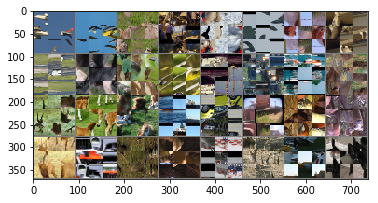

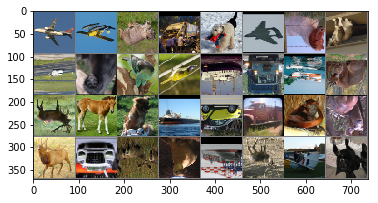

In [4]:
batch_size = 32
dataset_dir = './data'

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.Resize(90),
     transforms.ToTensor(),
     transforms.Normalize((img_mean, img_mean, img_mean), (img_std, img_std, img_std))])

train_set = torchvision.datasets.STL10(root=dataset_dir, split='train', download=True, transform=transform)

# Plot some training samples.
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=0)
dataiter = iter(sample_loader)
images, labels = next(dataiter)

p_images, perms = permute2x2(images)
# print("perms: {}".format(perms))


# Check the implementation of perm2vecmat and vecmat2perm.
assert(vecmat2perm2x2(perm2vecmat2x2(perms)).equal(perms))

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore2x2(p_images, perms)))

In [9]:
# Prepare training, validation, and test samples.
validation_ratio = 0.1
total = len(train_set)
ind = list(range(total))
n_train = int(np.floor((1. - validation_ratio) * total))
train_ind, validation_ind = ind[:n_train], ind[n_train:]
train_subsampler = torch.utils.data.sampler.SubsetRandomSampler(train_ind)
validation_subsampler = torch.utils.data.sampler.SubsetRandomSampler(validation_ind)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_subsampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                sampler=validation_subsampler, num_workers=0)

print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(validation_loader)))

test_set = torchvision.datasets.STL10(root=dataset_dir, split='test', download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

Number of training batches: 141
Number of validation batches: 16
Files already downloaded and verified


In [10]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def sinkhorn(A, n_iter=4):
    """
    Sinkhorn iterations.
    """
    
    for i in range(n_iter):
        A = A.clone()/A.sum(dim=1, keepdim=True)
        A = A.clone()/A.sum(dim=2, keepdim=True)

#     l = 0
#     for i in range(A.size()[2]):
#         maxvals, ind = A.max(2)
#         maxest, newind = maxvals.max(1)
#         A[:, newind, :] = 0
#         A[:, :, ind] = 0
#         for j,k in zip(newind, ind):
#             A[:, j, k] = maxest[l]
#             l += 1
            
#     print A
    return A

class SimpleConvNet(nn.Module):
    """
    A simple convolutional neural network shared among all pieces.
    """
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        # 3 x 16 x 16 input
        self.conv1 = nn.Conv2d(3, 8, 3)
        # 8 x 14 x 14
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.conv2_bn = nn.BatchNorm2d(8)
        # 8 x 12 x 12
        self.pool1 = nn.MaxPool2d(2, 2)
        # 8 x 6 x 6
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.conv3_bn = nn.BatchNorm2d(16)
        # 16 x 4 x 4
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        # 128-d features
        self.fc2 = nn.Linear(128, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        return x

class JigsawNet(nn.Module):
    """
    A neural network that solves 2x2 jigsaw puzzles.
    """
    def __init__(self, sinkhorn_iter=0):
        super(JigsawNet, self).__init__()
        vggmodel = vgg.__dict__["vgg11_bn"]()
#         print(vggmodel)
        vggmodel.features = torch.nn.DataParallel(vggmodel.features)
        self.conv_net = vggmodel
        self.fc1 = nn.Linear(9*512, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        # 4 x 4 assigment matrix
        self.fc2 = nn.Linear(256, 81)
        self.sinkhorn_iter = sinkhorn_iter
    
    def forward(self, x):
        # Split the input into four pieces and pass them into the
        # same convolutional neural network.
        x0 = self.conv_net(x[:, :, 0:30, 0:30])
        x1 = self.conv_net(x[:, :, 30:60, 0:30])
        x2 = self.conv_net(x[:, :, 60:90, 0:30])
        x3 = self.conv_net(x[:, :, 0:30, 30:60])
        x4 = self.conv_net(x[:, :, 30:60, 30:60])
        x5 = self.conv_net(x[:, :, 60:90, 30:60])
        x6 = self.conv_net(x[:, :, 0:30, 60:90])
        x7 = self.conv_net(x[:, :, 30:60, 60:90])
        x8 = self.conv_net(x[:, :, 60:90, 60:90])
        # Cat
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7, x8], dim=1)
        # Dense layer
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.sigmoid(self.fc2(x))
        if self.sinkhorn_iter > 0:
            x = x.view(-1, 9, 9)
            x = sinkhorn(x, self.sinkhorn_iter)
            x = x.view(-1, 81)
        return x

In [11]:
# Test helper
def compute_acc(p_pred, p_true, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    n = torch.sum((torch.sum(p_pred == p_true, 1)/9).float())
    if average:
        return n / p_pred.size()[0]
    else:
        return n

# Training process
def train_model(model, criterion, optimizer, train_loader, validation_loader,
                n_epochs=40, save_file_name=None):
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []
    for epoch in range(n_epochs):
        with tqdm_notebook(total=len(train_loader), desc="Epoch {}".format(epoch + 1), unit='b', leave=False) as pbar:
            # Training phase
            model.train()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(train_loader, 0):
                inputs, _ = data
                x_in, perms = permute2x2(inputs)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                optimizer.zero_grad()
                outputs = model(x_in)
                n_correct_pred += compute_acc(vecmat2perm2x2(outputs), perms, False).data[0]
                loss = criterion(outputs, y_in)
                loss.backward()
                optimizer.step()
                running_loss += loss.data[0] * x_in.size()[0]
                pbar.update(1)
            loss_history.append(running_loss / n_samples)
            acc_history.append(n_correct_pred / n_samples)
            
            # Validation phase
            model.eval()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(validation_loader, 0):
                inputs, _ = data
                x_in, perms = permute2x2(inputs)
                y_in = perm2vecmat2x2(perms)
                n_samples += inputs.size()[0]
                if is_cuda_available:
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                outputs = model(x_in)
                n_correct_pred += compute_acc(vecmat2perm2x2(outputs), perms, False).data[0]
                loss = criterion(outputs, y_in)
                running_loss += loss.data[0] * x_in.size()[0]
            val_loss_history.append(running_loss / n_samples)
            val_acc_history.append(n_correct_pred / n_samples)
            
            # Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history

# Test process
# Compute the accuracy
def test_model(model, test_loader):
    running_acc = 0.
    n = 0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, _ = data
        x_in, perms = permute2x2(inputs)
        y_in = perm2vecmat2x2(perms)
        if is_cuda_available:
            x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
        else:
            x_in, y_in = Variable(x_in), Variable(y_in)
        pred = model(x_in)
        perms_pred = vecmat2perm2x2(pred.cpu().data)
        running_acc += compute_acc(perms_pred, perms, False)
        n += x_in.size()[0]
    acc = running_acc / n
    return acc

In [12]:
n_epochs = 100
sinkhorn_iter = 10

# Create the neural network.
model = JigsawNet(sinkhorn_iter=sinkhorn_iter)
is_cuda_available = torch.cuda.is_available();
if is_cuda_available:
    model.cuda()

n_params = 0
for p in model.parameters():
    n_params += np.prod(p.size())
print('# of parameters: {}'.format(n_params))

# We use binary cross-entropy loss here.
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train
save_file_name = 'jigsaw_cifar100_e{}_s{}.pk'.format(n_epochs, sinkhorn_iter)
history = train_model(model, criterion, optimizer, train_loader, validation_loader,
                      n_epochs=n_epochs, save_file_name=save_file_name)

# of parameters: 3875163


HBox(children=(IntProgress(value=0, description='Epoch 1', max=141), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 001: loss=0.3489, val_loss=0.3462, acc=0.00%, val_acc=0.00%


HBox(children=(IntProgress(value=0, description='Epoch 2', max=141), HTML(value='')))

Epoch 002: loss=0.3435, val_loss=0.3363, acc=0.00%, val_acc=0.00%


HBox(children=(IntProgress(value=0, description='Epoch 3', max=141), HTML(value='')))

Epoch 003: loss=0.3340, val_loss=0.3216, acc=0.00%, val_acc=0.00%


HBox(children=(IntProgress(value=0, description='Epoch 4', max=141), HTML(value='')))

Epoch 004: loss=0.3212, val_loss=0.3106, acc=0.00%, val_acc=0.00%


HBox(children=(IntProgress(value=0, description='Epoch 5', max=141), HTML(value='')))

Epoch 005: loss=0.3130, val_loss=0.3071, acc=0.02%, val_acc=0.00%


HBox(children=(IntProgress(value=0, description='Epoch 6', max=141), HTML(value='')))

Epoch 006: loss=0.3054, val_loss=0.2980, acc=0.02%, val_acc=0.00%


HBox(children=(IntProgress(value=0, description='Epoch 7', max=141), HTML(value='')))

Epoch 007: loss=0.3003, val_loss=0.2907, acc=0.00%, val_acc=0.00%


HBox(children=(IntProgress(value=0, description='Epoch 8', max=141), HTML(value='')))

Epoch 008: loss=0.2947, val_loss=0.2881, acc=0.00%, val_acc=0.00%


HBox(children=(IntProgress(value=0, description='Epoch 9', max=141), HTML(value='')))

Epoch 009: loss=0.2913, val_loss=0.2829, acc=0.11%, val_acc=0.20%


HBox(children=(IntProgress(value=0, description='Epoch 10', max=141), HTML(value='')))

Epoch 010: loss=0.2862, val_loss=0.2801, acc=0.31%, val_acc=0.40%


HBox(children=(IntProgress(value=0, description='Epoch 11', max=141), HTML(value='')))

Epoch 011: loss=0.2831, val_loss=0.2769, acc=0.20%, val_acc=1.00%


HBox(children=(IntProgress(value=0, description='Epoch 12', max=141), HTML(value='')))

Epoch 012: loss=0.2801, val_loss=0.2718, acc=0.40%, val_acc=0.60%


HBox(children=(IntProgress(value=0, description='Epoch 13', max=141), HTML(value='')))

Epoch 013: loss=0.2779, val_loss=0.2733, acc=0.40%, val_acc=0.60%


HBox(children=(IntProgress(value=0, description='Epoch 14', max=141), HTML(value='')))

Epoch 014: loss=0.2746, val_loss=0.2708, acc=0.58%, val_acc=1.00%


HBox(children=(IntProgress(value=0, description='Epoch 15', max=141), HTML(value='')))

Epoch 015: loss=0.2728, val_loss=0.2695, acc=0.64%, val_acc=1.40%


HBox(children=(IntProgress(value=0, description='Epoch 16', max=141), HTML(value='')))

Epoch 016: loss=0.2704, val_loss=0.2684, acc=0.84%, val_acc=1.40%


HBox(children=(IntProgress(value=0, description='Epoch 17', max=141), HTML(value='')))

Epoch 017: loss=0.2680, val_loss=0.2638, acc=0.98%, val_acc=1.40%


HBox(children=(IntProgress(value=0, description='Epoch 18', max=141), HTML(value='')))

Epoch 018: loss=0.2667, val_loss=0.2633, acc=0.82%, val_acc=0.80%


HBox(children=(IntProgress(value=0, description='Epoch 19', max=141), HTML(value='')))

Epoch 019: loss=0.2644, val_loss=0.2624, acc=0.82%, val_acc=1.40%


HBox(children=(IntProgress(value=0, description='Epoch 20', max=141), HTML(value='')))

Epoch 020: loss=0.2624, val_loss=0.2613, acc=0.93%, val_acc=1.20%


HBox(children=(IntProgress(value=0, description='Epoch 21', max=141), HTML(value='')))

Epoch 021: loss=0.2601, val_loss=0.2613, acc=1.47%, val_acc=0.60%


HBox(children=(IntProgress(value=0, description='Epoch 22', max=141), HTML(value='')))

Epoch 022: loss=0.2589, val_loss=0.2595, acc=1.67%, val_acc=2.40%


HBox(children=(IntProgress(value=0, description='Epoch 23', max=141), HTML(value='')))

Epoch 023: loss=0.2583, val_loss=0.2626, acc=1.38%, val_acc=2.00%


HBox(children=(IntProgress(value=0, description='Epoch 24', max=141), HTML(value='')))

Epoch 024: loss=0.2553, val_loss=0.2570, acc=2.04%, val_acc=4.20%


HBox(children=(IntProgress(value=0, description='Epoch 25', max=141), HTML(value='')))

Epoch 025: loss=0.2542, val_loss=0.2566, acc=1.82%, val_acc=1.40%


HBox(children=(IntProgress(value=0, description='Epoch 26', max=141), HTML(value='')))

Epoch 026: loss=0.2518, val_loss=0.2558, acc=2.13%, val_acc=2.40%


HBox(children=(IntProgress(value=0, description='Epoch 27', max=141), HTML(value='')))

Epoch 027: loss=0.2503, val_loss=0.2563, acc=2.09%, val_acc=2.80%


HBox(children=(IntProgress(value=0, description='Epoch 28', max=141), HTML(value='')))

Epoch 028: loss=0.2494, val_loss=0.2572, acc=2.20%, val_acc=2.20%


HBox(children=(IntProgress(value=0, description='Epoch 29', max=141), HTML(value='')))

Epoch 029: loss=0.2470, val_loss=0.2516, acc=2.47%, val_acc=4.20%


HBox(children=(IntProgress(value=0, description='Epoch 30', max=141), HTML(value='')))

Epoch 030: loss=0.2460, val_loss=0.2544, acc=2.24%, val_acc=4.00%


HBox(children=(IntProgress(value=0, description='Epoch 31', max=141), HTML(value='')))

Epoch 031: loss=0.2433, val_loss=0.2513, acc=2.69%, val_acc=3.20%


HBox(children=(IntProgress(value=0, description='Epoch 32', max=141), HTML(value='')))

Epoch 032: loss=0.2411, val_loss=0.2561, acc=2.78%, val_acc=3.40%


HBox(children=(IntProgress(value=0, description='Epoch 33', max=141), HTML(value='')))

Epoch 033: loss=0.2406, val_loss=0.2531, acc=2.76%, val_acc=2.80%


HBox(children=(IntProgress(value=0, description='Epoch 34', max=141), HTML(value='')))

Epoch 034: loss=0.2387, val_loss=0.2503, acc=3.04%, val_acc=2.80%


HBox(children=(IntProgress(value=0, description='Epoch 35', max=141), HTML(value='')))

Epoch 035: loss=0.2376, val_loss=0.2559, acc=3.18%, val_acc=3.00%


HBox(children=(IntProgress(value=0, description='Epoch 36', max=141), HTML(value='')))

Epoch 036: loss=0.2354, val_loss=0.2523, acc=3.69%, val_acc=2.80%


HBox(children=(IntProgress(value=0, description='Epoch 37', max=141), HTML(value='')))

Epoch 037: loss=0.2338, val_loss=0.2558, acc=3.42%, val_acc=3.00%


HBox(children=(IntProgress(value=0, description='Epoch 38', max=141), HTML(value='')))

Epoch 038: loss=0.2326, val_loss=0.2539, acc=3.73%, val_acc=2.80%


HBox(children=(IntProgress(value=0, description='Epoch 39', max=141), HTML(value='')))

Epoch 039: loss=0.2297, val_loss=0.2549, acc=4.44%, val_acc=3.20%


HBox(children=(IntProgress(value=0, description='Epoch 40', max=141), HTML(value='')))

Epoch 040: loss=0.2278, val_loss=0.2550, acc=4.33%, val_acc=4.40%


HBox(children=(IntProgress(value=0, description='Epoch 41', max=141), HTML(value='')))

Epoch 041: loss=0.2265, val_loss=0.2545, acc=4.29%, val_acc=4.40%


HBox(children=(IntProgress(value=0, description='Epoch 42', max=141), HTML(value='')))

Epoch 042: loss=0.2239, val_loss=0.2599, acc=5.00%, val_acc=3.60%


HBox(children=(IntProgress(value=0, description='Epoch 43', max=141), HTML(value='')))

Epoch 043: loss=0.2229, val_loss=0.2559, acc=5.22%, val_acc=3.80%


HBox(children=(IntProgress(value=0, description='Epoch 44', max=141), HTML(value='')))

Epoch 044: loss=0.2215, val_loss=0.2606, acc=5.31%, val_acc=5.00%


HBox(children=(IntProgress(value=0, description='Epoch 45', max=141), HTML(value='')))

Epoch 045: loss=0.2184, val_loss=0.2601, acc=5.69%, val_acc=4.40%


HBox(children=(IntProgress(value=0, description='Epoch 46', max=141), HTML(value='')))

Epoch 046: loss=0.2161, val_loss=0.2609, acc=6.33%, val_acc=3.60%


HBox(children=(IntProgress(value=0, description='Epoch 47', max=141), HTML(value='')))

Epoch 047: loss=0.2154, val_loss=0.2626, acc=6.40%, val_acc=4.00%


HBox(children=(IntProgress(value=0, description='Epoch 48', max=141), HTML(value='')))

Epoch 048: loss=0.2121, val_loss=0.2618, acc=7.27%, val_acc=3.80%


HBox(children=(IntProgress(value=0, description='Epoch 49', max=141), HTML(value='')))

Epoch 049: loss=0.2106, val_loss=0.2608, acc=6.62%, val_acc=3.20%


HBox(children=(IntProgress(value=0, description='Epoch 50', max=141), HTML(value='')))

Epoch 050: loss=0.2094, val_loss=0.2597, acc=7.20%, val_acc=3.60%


HBox(children=(IntProgress(value=0, description='Epoch 51', max=141), HTML(value='')))

Epoch 051: loss=0.2052, val_loss=0.2676, acc=7.64%, val_acc=3.40%


HBox(children=(IntProgress(value=0, description='Epoch 52', max=141), HTML(value='')))

Epoch 052: loss=0.2036, val_loss=0.2607, acc=9.11%, val_acc=4.20%


HBox(children=(IntProgress(value=0, description='Epoch 53', max=141), HTML(value='')))

Epoch 053: loss=0.2009, val_loss=0.2633, acc=8.96%, val_acc=4.00%


HBox(children=(IntProgress(value=0, description='Epoch 54', max=141), HTML(value='')))

Epoch 054: loss=0.1977, val_loss=0.2670, acc=9.24%, val_acc=4.40%


HBox(children=(IntProgress(value=0, description='Epoch 55', max=141), HTML(value='')))

Epoch 055: loss=0.1984, val_loss=0.2676, acc=9.58%, val_acc=5.40%


HBox(children=(IntProgress(value=0, description='Epoch 56', max=141), HTML(value='')))

Epoch 056: loss=0.1954, val_loss=0.2628, acc=9.11%, val_acc=5.20%


HBox(children=(IntProgress(value=0, description='Epoch 57', max=141), HTML(value='')))

Epoch 057: loss=0.1931, val_loss=0.2714, acc=9.78%, val_acc=4.40%


HBox(children=(IntProgress(value=0, description='Epoch 58', max=141), HTML(value='')))

Epoch 058: loss=0.1901, val_loss=0.2671, acc=11.47%, val_acc=2.00%


HBox(children=(IntProgress(value=0, description='Epoch 59', max=141), HTML(value='')))

Epoch 059: loss=0.1894, val_loss=0.2727, acc=11.58%, val_acc=3.80%


HBox(children=(IntProgress(value=0, description='Epoch 60', max=141), HTML(value='')))

Epoch 060: loss=0.1870, val_loss=0.2785, acc=11.96%, val_acc=5.60%


HBox(children=(IntProgress(value=0, description='Epoch 61', max=141), HTML(value='')))

Epoch 061: loss=0.1837, val_loss=0.2763, acc=12.64%, val_acc=4.60%


HBox(children=(IntProgress(value=0, description='Epoch 62', max=141), HTML(value='')))

Epoch 062: loss=0.1818, val_loss=0.2777, acc=13.04%, val_acc=4.20%


HBox(children=(IntProgress(value=0, description='Epoch 63', max=141), HTML(value='')))

Epoch 063: loss=0.1781, val_loss=0.2822, acc=13.98%, val_acc=5.40%


HBox(children=(IntProgress(value=0, description='Epoch 64', max=141), HTML(value='')))

Epoch 064: loss=0.1773, val_loss=0.2935, acc=13.78%, val_acc=4.20%


HBox(children=(IntProgress(value=0, description='Epoch 65', max=141), HTML(value='')))

Epoch 065: loss=0.1738, val_loss=0.2896, acc=15.53%, val_acc=3.80%


HBox(children=(IntProgress(value=0, description='Epoch 66', max=141), HTML(value='')))

Epoch 066: loss=0.1700, val_loss=0.2918, acc=16.02%, val_acc=4.40%


HBox(children=(IntProgress(value=0, description='Epoch 67', max=141), HTML(value='')))

Epoch 067: loss=0.1684, val_loss=0.2997, acc=17.18%, val_acc=4.00%


HBox(children=(IntProgress(value=0, description='Epoch 68', max=141), HTML(value='')))

Epoch 068: loss=0.1671, val_loss=0.2967, acc=17.73%, val_acc=4.20%


HBox(children=(IntProgress(value=0, description='Epoch 69', max=141), HTML(value='')))

Epoch 069: loss=0.1665, val_loss=0.2941, acc=17.44%, val_acc=5.60%


HBox(children=(IntProgress(value=0, description='Epoch 70', max=141), HTML(value='')))

Epoch 070: loss=0.1636, val_loss=0.3141, acc=18.69%, val_acc=3.40%


HBox(children=(IntProgress(value=0, description='Epoch 71', max=141), HTML(value='')))

Epoch 071: loss=0.1603, val_loss=0.3012, acc=19.18%, val_acc=4.00%


HBox(children=(IntProgress(value=0, description='Epoch 72', max=141), HTML(value='')))

Epoch 072: loss=0.1595, val_loss=0.2948, acc=20.09%, val_acc=4.20%


HBox(children=(IntProgress(value=0, description='Epoch 73', max=141), HTML(value='')))

Epoch 073: loss=0.1576, val_loss=0.3197, acc=20.33%, val_acc=2.20%


HBox(children=(IntProgress(value=0, description='Epoch 74', max=141), HTML(value='')))

Epoch 074: loss=0.1541, val_loss=0.3059, acc=20.62%, val_acc=3.80%


HBox(children=(IntProgress(value=0, description='Epoch 75', max=141), HTML(value='')))

Epoch 075: loss=0.1522, val_loss=0.3014, acc=21.42%, val_acc=3.60%


HBox(children=(IntProgress(value=0, description='Epoch 76', max=141), HTML(value='')))

Epoch 076: loss=0.1488, val_loss=0.3199, acc=22.82%, val_acc=3.60%


HBox(children=(IntProgress(value=0, description='Epoch 77', max=141), HTML(value='')))

Epoch 077: loss=0.1476, val_loss=0.3158, acc=23.80%, val_acc=4.20%


HBox(children=(IntProgress(value=0, description='Epoch 78', max=141), HTML(value='')))

Epoch 078: loss=0.1446, val_loss=0.3238, acc=24.91%, val_acc=3.80%


HBox(children=(IntProgress(value=0, description='Epoch 79', max=141), HTML(value='')))

Epoch 079: loss=0.1426, val_loss=0.3379, acc=24.71%, val_acc=4.80%


HBox(children=(IntProgress(value=0, description='Epoch 80', max=141), HTML(value='')))

Epoch 080: loss=0.1410, val_loss=0.3259, acc=26.29%, val_acc=3.60%


HBox(children=(IntProgress(value=0, description='Epoch 81', max=141), HTML(value='')))

Epoch 081: loss=0.1407, val_loss=0.3287, acc=26.76%, val_acc=2.60%


HBox(children=(IntProgress(value=0, description='Epoch 82', max=141), HTML(value='')))

Epoch 082: loss=0.1375, val_loss=0.3337, acc=26.93%, val_acc=4.00%


HBox(children=(IntProgress(value=0, description='Epoch 83', max=141), HTML(value='')))

Epoch 083: loss=0.1350, val_loss=0.3196, acc=27.09%, val_acc=6.40%


HBox(children=(IntProgress(value=0, description='Epoch 84', max=141), HTML(value='')))

Epoch 084: loss=0.1320, val_loss=0.3399, acc=28.93%, val_acc=3.80%


HBox(children=(IntProgress(value=0, description='Epoch 85', max=141), HTML(value='')))

Epoch 085: loss=0.1316, val_loss=0.3447, acc=29.44%, val_acc=4.60%


HBox(children=(IntProgress(value=0, description='Epoch 86', max=141), HTML(value='')))

Epoch 086: loss=0.1297, val_loss=0.3329, acc=28.82%, val_acc=3.40%


HBox(children=(IntProgress(value=0, description='Epoch 87', max=141), HTML(value='')))

Epoch 087: loss=0.1277, val_loss=0.3581, acc=30.33%, val_acc=3.40%


HBox(children=(IntProgress(value=0, description='Epoch 88', max=141), HTML(value='')))

Epoch 088: loss=0.1253, val_loss=0.3515, acc=31.69%, val_acc=4.20%


HBox(children=(IntProgress(value=0, description='Epoch 89', max=141), HTML(value='')))

Epoch 089: loss=0.1238, val_loss=0.3419, acc=32.47%, val_acc=5.00%


HBox(children=(IntProgress(value=0, description='Epoch 90', max=141), HTML(value='')))

Epoch 090: loss=0.1222, val_loss=0.3537, acc=33.00%, val_acc=4.00%


HBox(children=(IntProgress(value=0, description='Epoch 91', max=141), HTML(value='')))

Epoch 091: loss=0.1239, val_loss=0.3640, acc=31.40%, val_acc=4.20%


HBox(children=(IntProgress(value=0, description='Epoch 92', max=141), HTML(value='')))

Epoch 092: loss=0.1192, val_loss=0.3659, acc=35.62%, val_acc=4.00%


HBox(children=(IntProgress(value=0, description='Epoch 93', max=141), HTML(value='')))

Epoch 093: loss=0.1171, val_loss=0.3778, acc=34.78%, val_acc=2.60%


HBox(children=(IntProgress(value=0, description='Epoch 94', max=141), HTML(value='')))

Epoch 094: loss=0.1150, val_loss=0.3732, acc=35.31%, val_acc=3.80%


HBox(children=(IntProgress(value=0, description='Epoch 95', max=141), HTML(value='')))

Epoch 095: loss=0.1135, val_loss=0.3626, acc=36.84%, val_acc=4.00%


HBox(children=(IntProgress(value=0, description='Epoch 96', max=141), HTML(value='')))

Epoch 096: loss=0.1109, val_loss=0.3729, acc=37.09%, val_acc=4.40%


HBox(children=(IntProgress(value=0, description='Epoch 97', max=141), HTML(value='')))

Epoch 097: loss=0.1104, val_loss=0.3872, acc=37.53%, val_acc=4.00%


HBox(children=(IntProgress(value=0, description='Epoch 98', max=141), HTML(value='')))

Epoch 098: loss=0.1089, val_loss=0.3798, acc=38.69%, val_acc=3.40%


HBox(children=(IntProgress(value=0, description='Epoch 99', max=141), HTML(value='')))

Epoch 099: loss=0.1073, val_loss=0.3896, acc=38.80%, val_acc=3.80%


HBox(children=(IntProgress(value=0, description='Epoch 100', max=141), HTML(value='')))

Epoch 100: loss=0.1061, val_loss=0.3841, acc=40.38%, val_acc=2.80%
Training completed


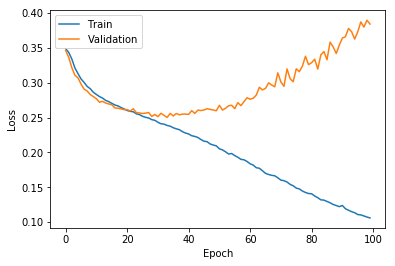

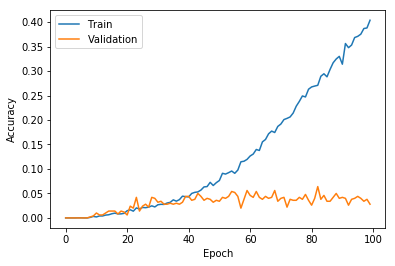

In [13]:
plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()
plt.figure()
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [14]:
# Calculate accuracy
print('Training accuracy: {}'.format(test_model(model, train_loader)))
print('Validation accuracy: {}'.format(test_model(model, validation_loader)))
print('Test accuracy: {}'.format(test_model(model, test_loader)))
# Here training accuracy will be higher because dropout is disabled

Training accuracy: 0.5655555725097656
Validation accuracy: 0.024000000208616257
Test accuracy: 0.023874999955296516


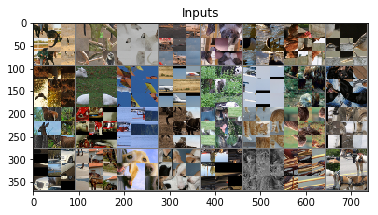

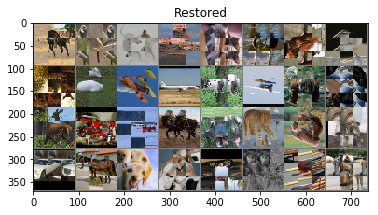

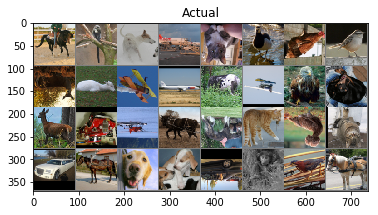

In [15]:
# Let us try some test images.
test_data_iter = iter(test_loader)
test_images, _ = test_data_iter.next()
p_images, perms = permute2x2(test_images)

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
plt.title('Inputs')
plt.show()

model.eval()
if is_cuda_available:
    pred = model(Variable(p_images.cuda()))
else:
    pred = model(Variable(p_images))
perms_pred = vecmat2perm2x2(pred.cpu().data)

# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore2x2(p_images, perms_pred)))
plt.title('Restored')
plt.show()

plt.figure()
imshow(torchvision.utils.make_grid(test_images))
plt.title('Actual')
plt.show()